In [ ]:
!mamba install control slycot 2>&1 >/dev/null

In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12,'font.family':'verdana'})
plt.rcParams['figure.dpi'] = 120
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Zeroes: [-1.35909091+4.56997703j -1.35909091-4.56997703j]
Poles:
    Eigenvalue (pole)       Damping     Frequency
      -1.5     +4.77j           0.3             5
      -1.5     -4.77j           0.3             5
      0.05   +0.2179j       -0.2236        0.2236
      0.05   -0.2179j       -0.2236        0.2236


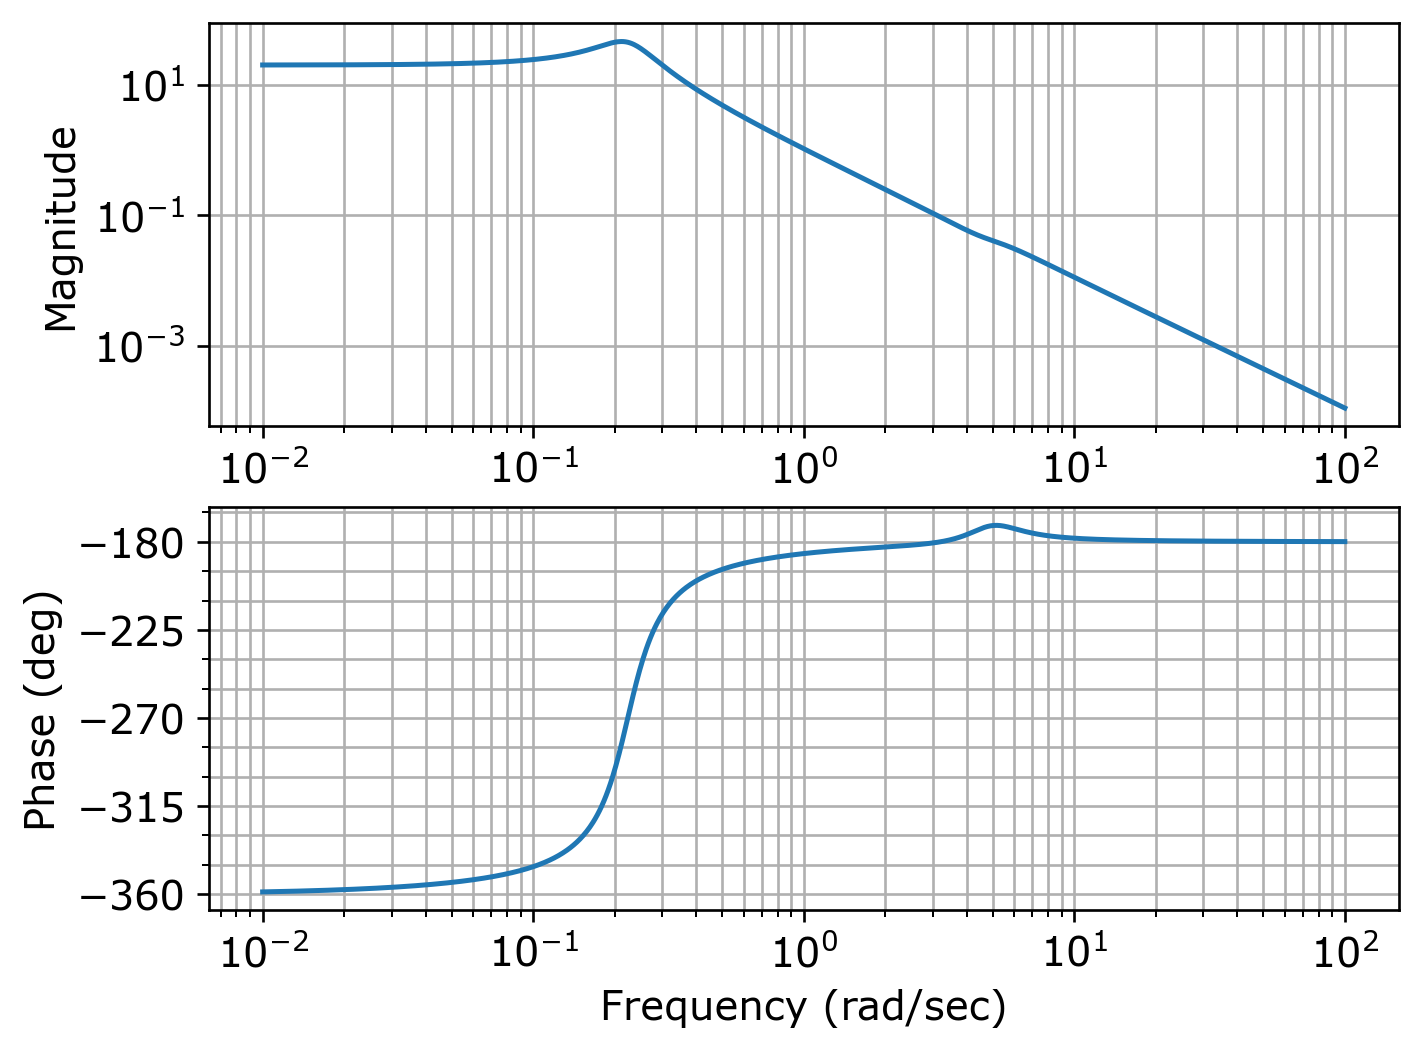

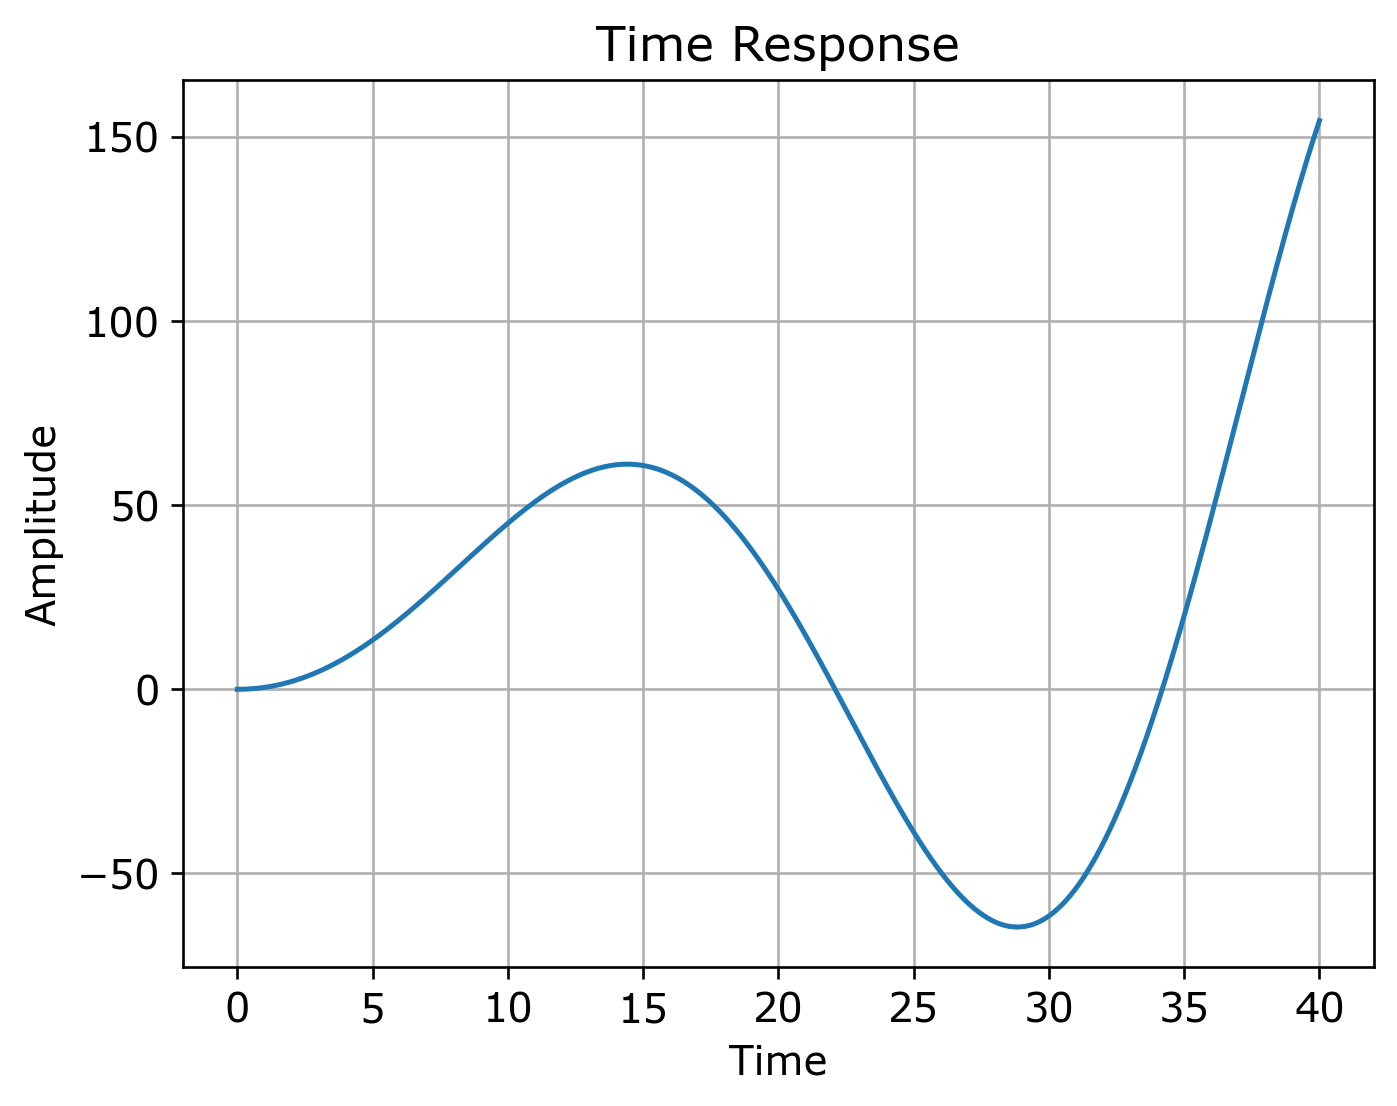

In [2]:
w = np.logspace(-2, 2, 1000)
t = np.linspace(0, 40, 1000)

alpha = 0.05
beta = 0 # beta = -1
G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
G = G1 + G2
print(f"Zeroes: {G.zero()}\nPoles:")
control.damp(G)
control.bode(G, w); plt.show()
t, y = control.step_response(G, t)
plt.plot(t, y); plt.title('Time Response'); plt.xlabel('Time'); plt.ylabel('Amplitude'); plt.grid(True); plt.show()

In [3]:
from ipywidgets import interact, widgets, fixed

G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
G = G1 + G2

def plot(wc_lead, ph_lead_deg, wc_lag, ph_lag_deg, t):
    global Ka, Kb, Kc

    # mag, ph, _ = control.bode(G, wc_lead, plot=False); K0 = wc_lead/mag
    # gm, pm, wg, wp = control.margin(G); print(f'Phase Margin: {pm*180/np.pi:.2f} deg')

    c_lead = np.tan(np.deg2rad((90+ph_lead_deg)/2)) # c_lead = np.sqrt(10) 
    Kb = c_lead * control.TransferFunction(np.array([1, wc_lead/c_lead]), np.array([1, wc_lead*c_lead]))

    c_lag = np.tan(np.deg2rad((90+ph_lag_deg)/2))
    Kc = control.TransferFunction(np.array([1, wc_lag*c_lag]), np.array([1, wc_lag/c_lag]))

    # control.bode([G, G*Kb, G*Kb*Kc], w, dB=True, initial_phase=0); # wrap_phase=True, margins=True
    control.bode(G, w, dB=True, initial_phase=0, label='G');
    control.bode(G*Kb, w, dB=True, initial_phase=0, label='G*Kb');
    control.bode(G*Kb*Kc, w, dB=True, initial_phase=0, label='G*Kb*Kc');
    plt.legend(loc='lower right'); plt.show()
    control.nyquist([G, G*Kb, G*Kb*Kc], w); 
    plt.axis('equal'); plt.show() # plt.legend(loc='lower right');
    # plt.xlim(-2, 2); plt.ylim(-2, 2); plt.show()

    CL = control.feedback(G*Kc, Kb) # CLTF
    mag, ph, _ = control.freqresp(CL, 0)
    Ka = 1/np.abs(mag)
    t, y = control.step_response(CL*Ka, t)
    plt.plot(t, y, color='black'); plt.title('Time Response'); plt.xlabel('Time'); plt.ylabel('Amplitude'); plt.grid(True); plt.show()

interact(plot, wc_lead=widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.75), ph_lead_deg=widgets.IntSlider(min=0, max=90, step=1, value=50), wc_lag=widgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.12), ph_lag_deg=widgets.IntSlider(min=0, max=90, step=1, value=28), t=fixed(t));


interactive(children=(FloatSlider(value=0.75, description='wc_lead', max=1.0, min=0.01, step=0.01), IntSlider(…

In [5]:
gm, pm, wcg, wcp = control.margin(G*Kc*Kb)
print(f'Gain Margin: {20 * np.log10(gm):.2f} dB')
print(f'Phase Margin: {pm:.2f} deg')
print(f'Gain Crossover: {wcg:.2f} rad/s')
print(f'Phase Crossover: {wcp:.2f} rad/s')

Gain Margin: -17.87 dB
Phase Margin: 36.02 deg
Gain Crossover: 0.36 rad/s
Phase Crossover: 1.22 rad/s


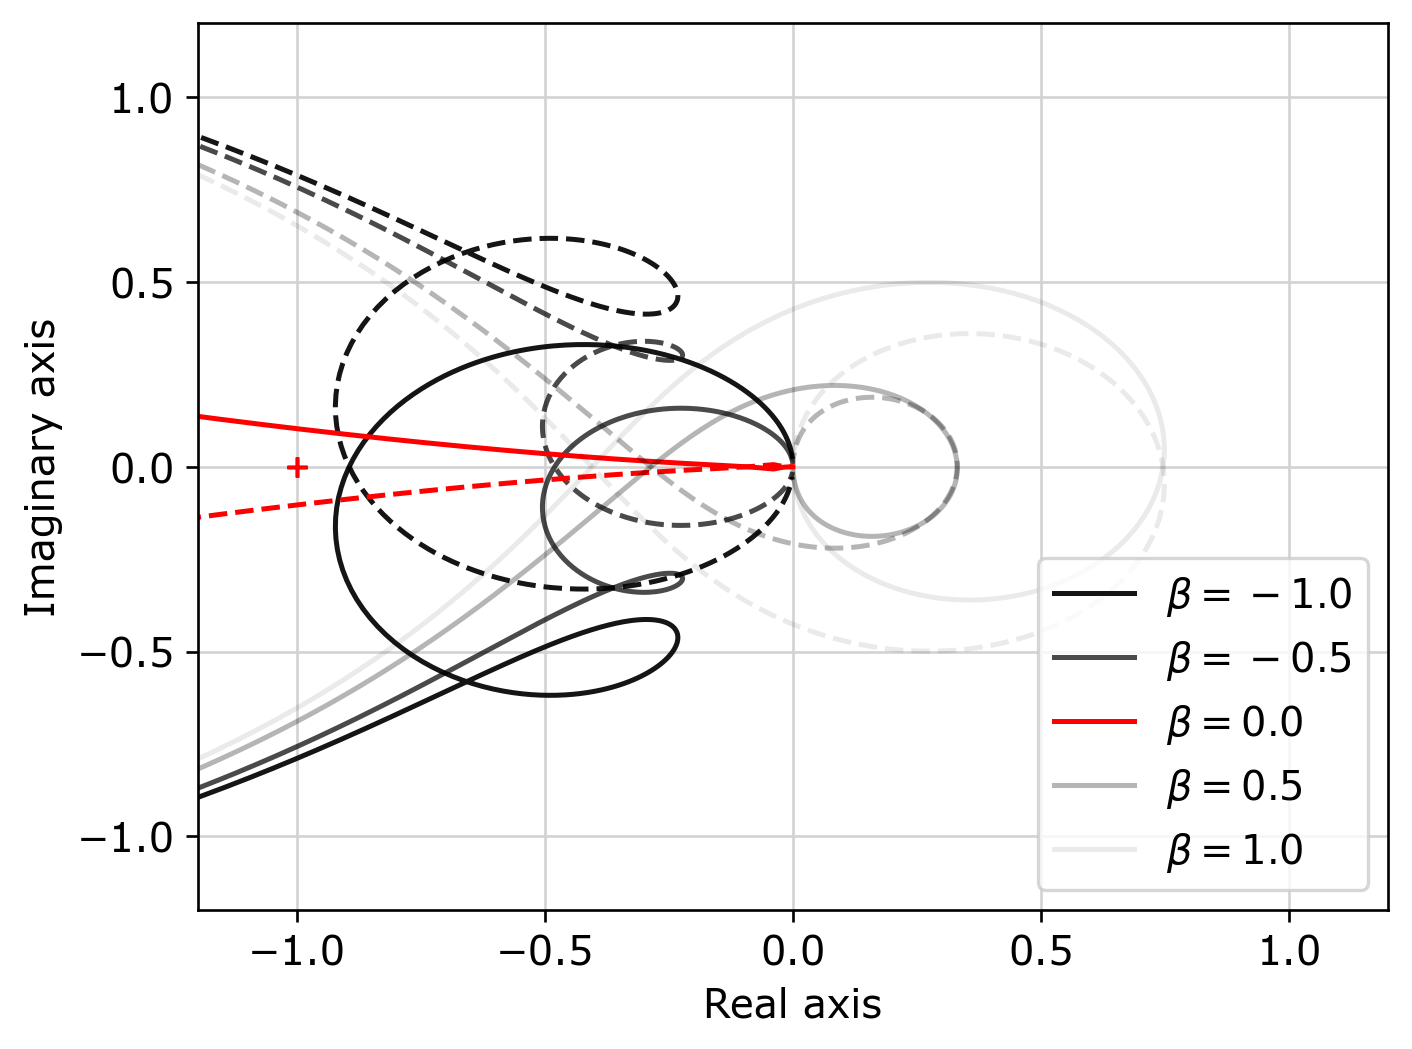

In [6]:
OL = G*Kc*Kb; alpha = 0.05
for beta in np.arange(-1, 1.2, 0.5):
    G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
    G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
    G = G1 + G2
    if beta == 0:
        plt.plot([],[], color='red', label=f"$\\beta={beta}$")
        control.nyquist(G, w, color='red')
    else:
        # continue
        plt.plot([],[], color='black', alpha=abs(beta-1.2)/2.4, label=f"$\\beta={beta}$")
        control.nyquist(G*Kc*Kb, w, color='black', alpha=abs(beta-1.2)/2.4);
plt.xlim(-1.2, 1.2); plt.ylim(-1.2, 1.2);
plt.legend(loc='lower right'); # plt.axis('equal')

In [7]:
alpha = 0.05
for beta in np.arange(-1, 1.2, 1):
    G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
    G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
    G = G1 + G2
    gm, pm, sm, gc, pc, sc = control.stability_margins(G*Kc*Kb)
    print(f'- Beta: {beta}')
    print(f'Gain Margin: {20 * np.log10(gm):.2f} dB | Phase Margin: {pm:.2f} deg | Stability Margin: {sm:.2f}')
    control.damp(1/(1+G*Kc*Kb))


- Beta: -1.0
Gain Margin: 0.97 dB | Phase Margin: 40.31 deg | Stability Margin: 0.10
    Eigenvalue (pole)       Damping     Frequency
   -0.1705    +5.476j       0.03112         5.479
   -0.1705    -5.476j       0.03112         5.479
   -0.5962    +1.028j        0.5017         1.188
   -0.5962    -1.028j        0.5017         1.188
              -0.5962             1        0.5962
              -0.1555             1        0.1555
- Beta: 0.0
Gain Margin: -17.87 dB | Phase Margin: 36.02 deg | Stability Margin: 0.58
    Eigenvalue (pole)       Damping     Frequency
     -1.51    +4.801j           0.3         5.033
     -1.51    -4.801j           0.3         5.033
    -0.627    +1.123j        0.4876         1.286
    -0.627    -1.123j        0.4876         1.286
              -0.6036             1        0.6036
              -0.1555             1        0.1555
- Beta: 1.0
Gain Margin: 7.85 dB | Phase Margin: 31.79 deg | Stability Margin: 0.47
    Eigenvalue (pole)       Damping     Frequ

In [8]:
def iter(Ka, Kb, Kc, t, alphas, betas):
    for alpha in alphas:
        for beta in betas:
            G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
            G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
            G = G1 + G2
            CL = control.feedback(G*Kc, Kb)
            t, y = control.step_response(CL*Ka, t)
            ss = control.step_info(CL*Ka)['SteadyStateValue']
            peak = control.step_info(CL*Ka)['Peak']
            print(f'- Alpha: {alpha:.3f}, Beta: {beta}')
            print(f'y(10)={np.interp(10, t, y):.3f} | y(∞)={ss:.5f} | y_max={max(peak,ss):.5f}')

alphas = np.arange(0.045, 0.0551, 0.005)
betas = np.arange(-1, 1.2, 1) # np.arange(-1, 1.2, 0.5)
iter(Ka, Kb, Kc, t, alphas, betas)

- Alpha: 0.045, Beta: -1.0
y(10)=0.955 | y(∞)=1.00475 | y_max=1.00475
- Alpha: 0.045, Beta: 0.0
y(10)=0.941 | y(∞)=1.00475 | y_max=1.00475
- Alpha: 0.045, Beta: 1.0
y(10)=0.940 | y(∞)=1.00475 | y_max=1.00475
- Alpha: 0.050, Beta: -1.0
y(10)=0.949 | y(∞)=1.00000 | y_max=1.00000
- Alpha: 0.050, Beta: 0.0
y(10)=0.934 | y(∞)=1.00000 | y_max=1.00000
- Alpha: 0.050, Beta: 1.0
y(10)=0.933 | y(∞)=1.00000 | y_max=1.00000
- Alpha: 0.055, Beta: -1.0
y(10)=0.943 | y(∞)=0.99530 | y_max=0.99530
- Alpha: 0.055, Beta: 0.0
y(10)=0.928 | y(∞)=0.99530 | y_max=0.99530
- Alpha: 0.055, Beta: 1.0
y(10)=0.927 | y(∞)=0.99530 | y_max=0.99530


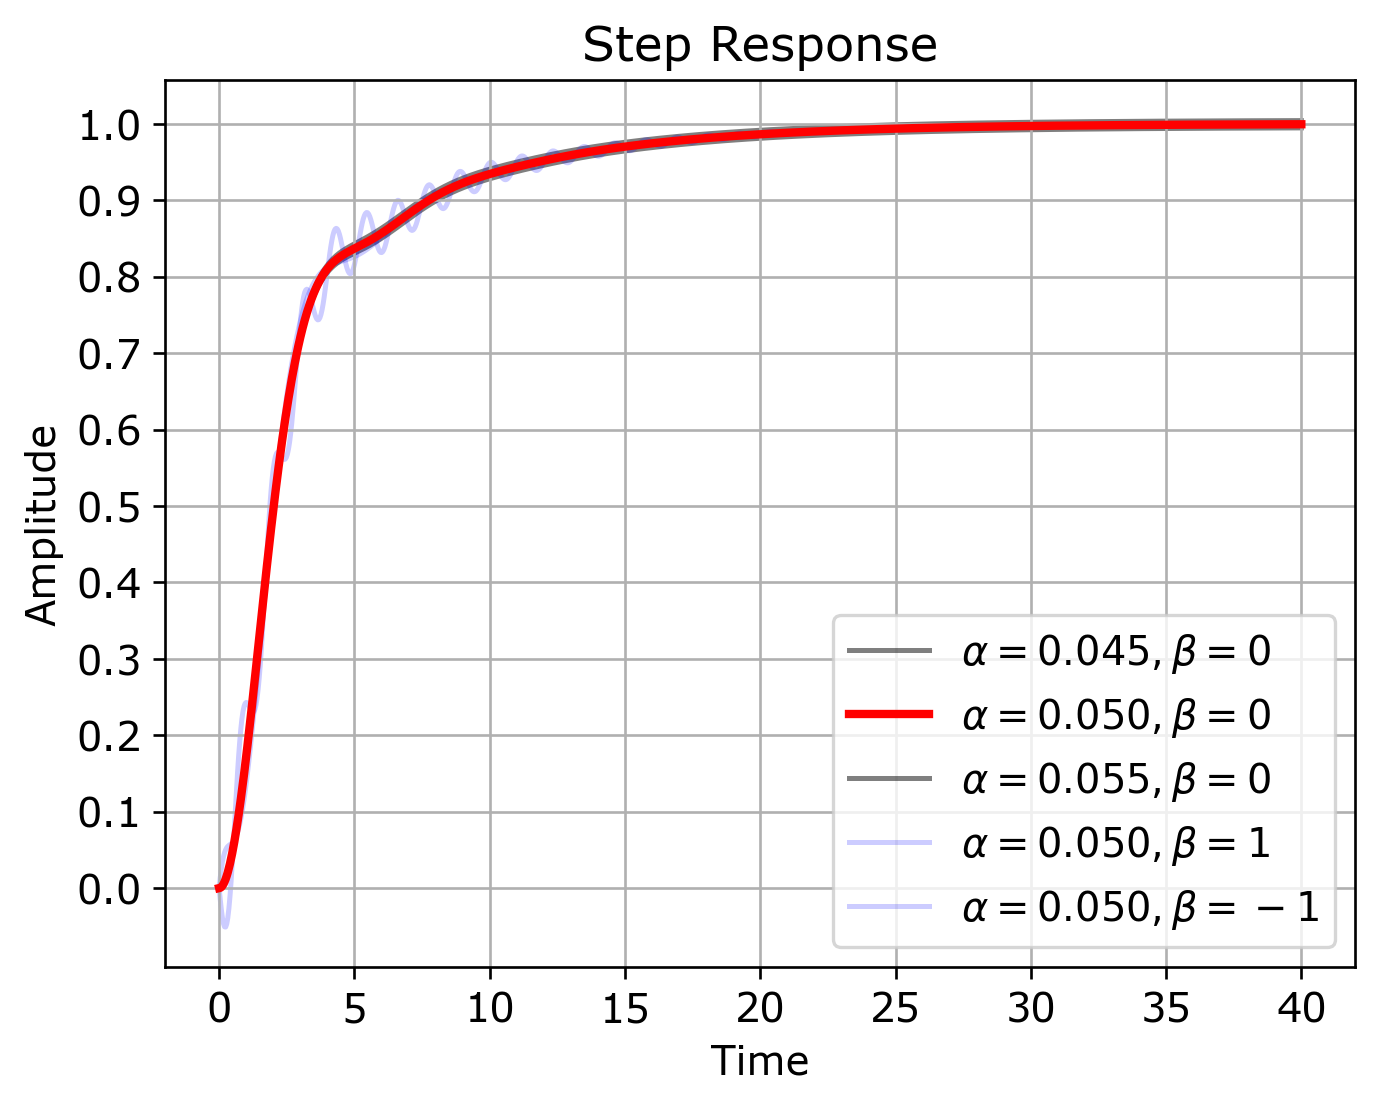

In [9]:
def iter(Ka, Kb, Kc, t, alphas, betas):
    for alpha in alphas:
        beta = 0 # for beta in betas:
        G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
        G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
        G = G1 + G2
        CL = control.feedback(G*Kc, Kb)
        t, y = control.step_response(CL*Ka, t)
        if round(alpha,3) == 0.050 and beta == 0:
            plt.plot(t, y, color='red', linewidth=2.5, label=f"$\\alpha={alpha:.3f}, \\beta={beta}$", zorder=10)
        else:
            plt.plot(t, y, color='black', alpha=0.5, label=f"$\\alpha={alpha:.3f}, \\beta={beta}$", zorder=1)
    for beta in betas:
        beta = -beta
        alpha = 0.05
        G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
        G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
        G = G1 + G2
        CL = control.feedback(G*Kc, Kb)
        t, y = control.step_response(CL*Ka, t)
        if round(alpha,3) == 0.050 and beta == 0:
            True
        else:
            plt.plot(t, y, color='blue', alpha=0.2, label=f"$\\alpha={alpha:.3f}, \\beta={beta:.0f}$", zorder=1)

alphas = np.arange(0.045, 0.0551, 0.005)
betas = np.arange(-1, 1.2, 1) # np.arange(-1, 1.2, 0.5)
iter(Ka, Kb, Kc, t, alphas, betas); plt.legend(loc='lower right')
plt.yticks(np.arange(0, 1.05, 0.1))
plt.title('Step Response'); plt.xlabel('Time'); plt.ylabel('Amplitude'); plt.grid(True); plt.show()

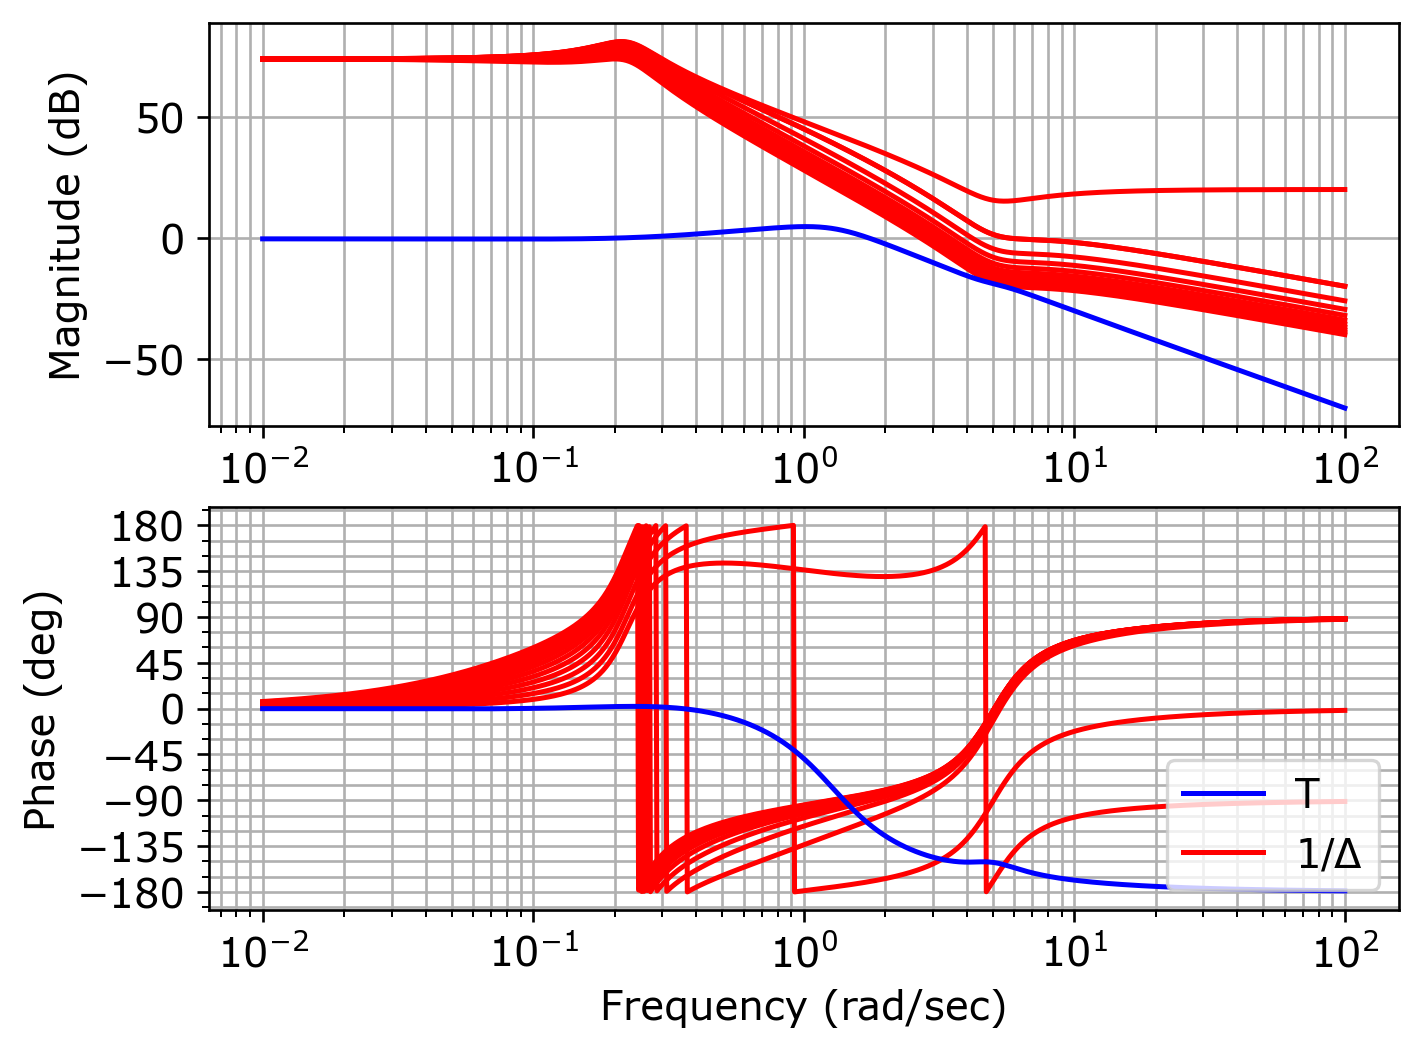

In [10]:
alpha = 0.05; beta = 0
G1 = control.TransferFunction(np.array([1]), np.array([1, -0.1, alpha]))
G2 = control.TransferFunction(np.array([beta, 0.1]), np.array([1, 3, 25]))
G = G1 + G2
# L = G*Kb*Kc; T = L / (1 + L)
T = Kb*Kc*G / (1+Kb*Kc*G)
for beta in np.arange(-1, 0.2, 0.1):
    delta = control.TransferFunction(np.polymul([beta, 0.1], [1, -0.1, alpha]), [1, 3, 25])
    control.bode(1/delta, w, dB=True, wrap_phase=True, color='red');
control.bode(T, w, dB=True, wrap_phase=True, color='blue', label='T');
plt.plot([],[], color='red', label=f"$1/\\Delta$")
plt.legend(loc='lower right'); plt.show()


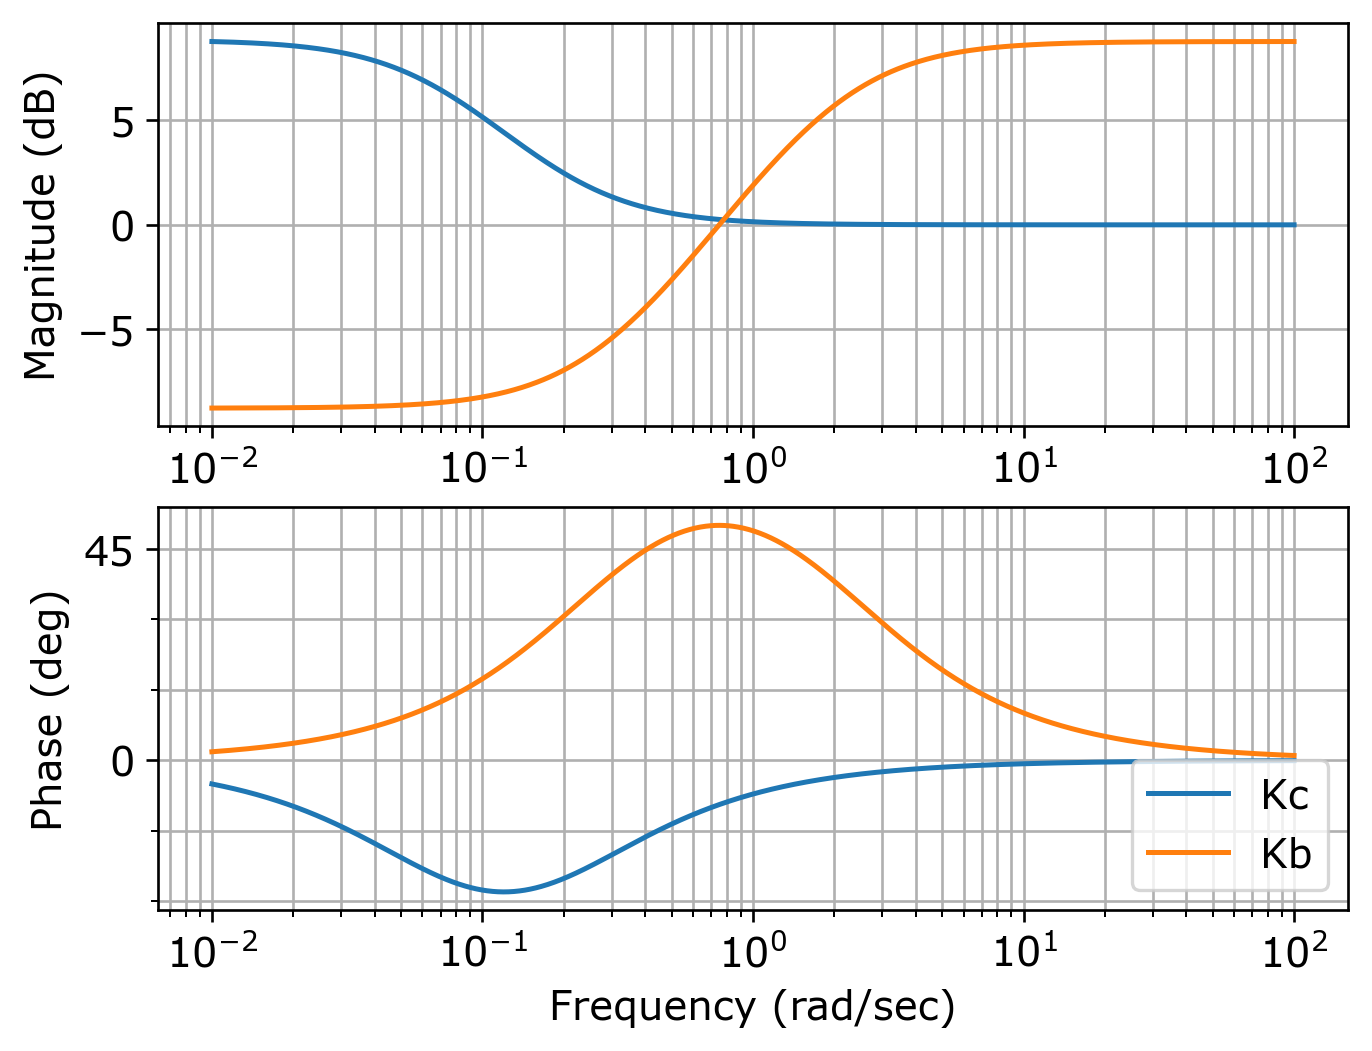

In [11]:
control.bode(Kc,w,dB=True, wrap_phase=True, label='Kc')
control.bode(Kb,w,dB=True, wrap_phase=True, label='Kb')
plt.legend(loc='lower right'); plt.show()

# MISC

In [ ]:
a = np.sqrt(10); wc = 1
mag, ph, _ = control.freqresp(G, wc)
K0 = 1/mag
K1 = control.TransferFunction(a * np.array([1, wc/a]), [1, a*wc])